# 1. Introuction

This notebook outlines the creation, compilation, and training of multiple ViT networks using both transfer learning and regular learning of the whole backbone. Transfer learning allows leveraging pre-trained models to achieve high accuracy with reasonable training times by fine-tuning for the specific task at hand, in this case for food recognition. For the sake of fair comparison, the traning process of the models will be configured with the same number of epochs, learning rate, and regularization. The values of these parameters have been determined based of previous experimentation.

The following table summarize the models:

| Version | **ViT Type** | **Image Size** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 1 | Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | None | Yes | 60 | 0.0001 | No | 85.9M |
| 2 | Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | 1024 | Yes | 60 | 0.0001 | No | 86.7M |
| 3 | Large | 224x224 | 16x16 | 24 | 1024 | 4096 | 16 | None | Yes | 60 | 0.0001 | No | 303.4M |
| 4 | Large | 224x224 | 16x16 | 24 | 1024 | 4096 | 16 | 1024 | Yes | 60 | 0.0001 | No | 304.5M |
| 5 | Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | None | No | 20 | 0.00001 | No | 85.9M |
| 6 | Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | 1024 | No | 20 | 0.00001 | No | 86.7M |
| 7 | Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | None | No | 10 | 0.0001 | CosineAnnealingLR | 85.9M |
| 8 | Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | 1024 | No | 10 | 0.0001 | CosineAnnealingLR | 86.7M |
| 9 | Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | Multiple | No | 10 | 0.0001 | CosineAnnealingLR | 87.9M |
| 10 | Large | 224x224 | 16x16 | 24 | 1024 | 4096 | 16 | None | No | 10 | 0.00001 | No | 303.4M |
| 11 | PyTorch's Default Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | None | No | 10 | 0.0001 | CosineAnnealingLR | 85.9M |
| 12 | Base | 256x256 | 16x16 | 12 | 768 | 3072 | 12 | None | No | 10 | 0.000001 | No | 85.9M |
| 13 | PyTorch's Default Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | None | No | 15 | 0.0001 | CosineAnnealingLR | 85.9M |

The transformer architectures have been implemented from scratch based on the paper titled ["An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale"](https://arxiv.org/abs/2010.11929). The custom library is called **vision_transformer** where the **ViT class** can be imported.

# 2. Importing Libraries

In [1]:
import os
import pandas as pd
import torch
import torchvision
import torch.backends.cudnn as cudnn

from torch import nn
from torchvision.transforms import v2
from torchinfo import summary
from pathlib import Path
from torchvision import datasets

# Import custom libraries
from modules.helper_functions import create_dataloaders, set_seeds, display_random_images, save_model, load_model
from modules.engine import train, Trainer
from modules.vision_transformer import ViT, ViTv2
#from modules.scheduler import WarmupCosineAnnealingLR
#from warmup_scheduler_pytorch import WarmUpScheduler
#from timm.scheduler.cosine_lr import CosineLRScheduler


# Define some constants
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 64
AMOUNT_TO_GET = 1.0
SEED = 42
ENABLE = {
    'train_model': True,
    'save_model':  True,    
}

# Define target data directory
target_dir_name = f"../data/food-101_{str(int(AMOUNT_TO_GET*100))}_percent"

# Setup training and test directories
target_dir = Path(target_dir_name)
TRAIN_DIR = target_dir / "train"
TEST_DIR = target_dir / "test"
target_dir.mkdir(parents=True, exist_ok=True)

# Create target model directory
model_dir = Path("../models")

# Set seeds
set_seeds(SEED)

TRAIN = {
    'model_1': True, #ViT-Base -   no classification hidden units -       transfer learning -    No scheduling
    'model_2': True, #ViT-Base -   1024 classification hidden units -     transfer learning -    No scheduling
    'model_3': True, #ViT-Large -  no classification hidden units -       transfer learning -    No scheduling
    'model_4': True, #ViT-Large -  1024 classification hidden units -     transfer learning -    No scheduling
    'model_5': True, #ViT-Base -   no classification hidden units -       no transfer learning - No scheduling
    'model_6': True, #ViT-Base -   1024 classification hidden units -     no transfer learning - No scheduling
    'model_7': True, #ViT-Base -   no classification hidden units -       no transfer learning - CosineAnnealingLR
    'model_8': True, #ViT-Base -   1024 classification hidden units -     no transfer learning - CosineAnnealingLR
    'model_9': True, #ViT-Base -   multiple classification hidden units - no transfer learning - CosineAnnealingLR
    'model_10': True, #ViT-Large - no classification hidden units -       no transfer learning - No scheduling
    'model_11': True, #ViT-Base -  no classification hidder units -       no transfer learning - CosineAnnealingLR - Pytorch's default network
    'model_12': True, #ViT-Base -  no classification hidder units -       no transfer learning - No scheduling - Increased image size (256x256)
    'model_13': True, #ViT-Base -  no classification hidder units -       no transfer learning - CosineAnnealingLR - 15 epochs
}

# 3. Specifying Target Device

In [2]:
# Activate cuda benchmark
cudnn.benchmark = True

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

if device == "cuda":
    !nvidia-smi

Device: cuda
Mon Dec 30 17:19:53 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   52C    P8             11W /  200W |    1002MiB /  12282MiB |      7%      Default |
|                                         |                        |                  N/A |
+----------------------------------

In [3]:
# Disable logging for Torch Dynamo
#torch._dynamo.config.suppress_errors = True

# Suppress specific PyTorch warnings
#warnings.filterwarnings('ignore', category=UserWarning, module='torch')

# Limit the number of threads to 1 to reduce the likelihood of cuDNN warnings
#torch.set_num_threads(1)

In [4]:
# Print list of available backends
#torch._dynamo.list_backends()

In [5]:
# Check if onnxrt is supported
#torch.onnx.is_onnxrt_backend_supported()

# 4. Dataloaders and Image Visualization

In [3]:
# Image size
IMG_SIZE = 224

def data_loaders(
        vit_model: str="bitbase16",
        train_dir: str=TRAIN_DIR,
        test_dir: str=TEST_DIR,
        batch_size: int=BATCH_SIZE,
        aug: bool=True,
        display_imgs: bool=True):

    # Manual transforms for the training dataset
    manual_transforms = v2.Compose([           
        v2.RandomCrop((IMG_SIZE, IMG_SIZE)),    
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),    
    ])

    # ViT-Base/16 transforms
    if vit_model == "vitbase16":

        # Manual transforms for the training dataset
        if aug:
            manual_transforms_train_vitb = v2.Compose([    
                v2.TrivialAugmentWide(),
                v2.Resize((256, 256)),
                v2.RandomCrop((IMG_SIZE, IMG_SIZE)),    
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]) 
            ])
        else:
            manual_transforms_train_vitb = v2.Compose([
                v2.Resize((256, 256)),
                v2.CenterCrop((IMG_SIZE, IMG_SIZE)),
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
            ])

        # Manual transforms for the test dataset
        manual_transforms_test_vitb = v2.Compose([    
            v2.Resize((256, 256)),
            v2.CenterCrop((IMG_SIZE, IMG_SIZE)),    
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]) 
        ])

        # Create data loaders for ViT-Base
        train_dataloader, test_dataloader, class_names = create_dataloaders(
            train_dir=train_dir,
            test_dir=test_dir,
            train_transform=manual_transforms_train_vitb,
            test_transform=manual_transforms_test_vitb,
            batch_size=batch_size,
            num_workers=NUM_WORKERS
            )
        
        # Get the pretrained ViT-Base weights
        pretrained_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

    # ViT-Large/16 transforms
    elif vit_model == "vitlarge16":

        # Manual transforms for the training dataset
        if aug:
            manual_transforms_train_vitl = v2.Compose([    
                v2.TrivialAugmentWide(),
                v2.Resize((242, 242)),
                v2.RandomCrop((IMG_SIZE, IMG_SIZE)),    
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]) 
            ])
        else:
            manual_transforms_train_vitl = v2.Compose([
                v2.Resize((242, 242)),
                v2.CenterCrop((IMG_SIZE, IMG_SIZE)),
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
            ])

        # Manual transforms for the test dataset
        manual_transforms_test_vitl = v2.Compose([    
            v2.Resize((242, 242)),
            v2.CenterCrop((IMG_SIZE, IMG_SIZE)),    
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]) 
        ])

        # Create data loaders for ViT-Large/16
        train_dataloader, test_dataloader, class_names = create_dataloaders(
            train_dir=train_dir,
            test_dir=test_dir,
            train_transform=manual_transforms_train_vitl,
            test_transform=manual_transforms_test_vitl,
            batch_size=batch_size
        )

        # Get the pretrained ViT-Large/16 weights
        pretrained_weights = torchvision.models.ViT_L_16_Weights.DEFAULT

    # ViT-Large/32 transforms
    else:
        # Manual transforms for the training dataset
        if aug:
            manual_transforms_train_vitl = v2.Compose([    
                v2.TrivialAugmentWide(),
                v2.Resize((256, 256)),
                v2.RandomCrop((IMG_SIZE, IMG_SIZE)),    
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]) 
            ])
        else:
            manual_transforms_train_vitl = v2.Compose([
                v2.Resize((256, 256)),
                v2.CenterCrop((IMG_SIZE, IMG_SIZE)),
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
            ])

        # Manual transforms for the test dataset
        manual_transforms_test_vitl = v2.Compose([    
            v2.Resize((256, 256)),
            v2.CenterCrop((IMG_SIZE, IMG_SIZE)),    
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]) 
        ])

        # Create data loaders for ViT-Large/32
        train_dataloader, test_dataloader, class_names = create_dataloaders(
            train_dir=train_dir,
            test_dir=test_dir,
            train_transform=manual_transforms_train_vitl,
            test_transform=manual_transforms_test_vitl,
            batch_size=batch_size
        )

        # Get the pretrained ViT-Large/32 weights
        pretrained_weights = torchvision.models.ViT_L_32_Weights.DEFAULT

    # Display images
    if display_imgs:
        train_data = datasets.ImageFolder(train_dir, transform=manual_transforms)
        display_random_images(train_data,
                        n=25,
                        classes=class_names,
                        rows=5,
                        cols=5,
                        display_shape=False,
                        seed=None)
    
    return train_dataloader, test_dataloader, class_names, pretrained_weights

# 5. Training

In [4]:
# Create Pytorch's default ViT models
def create_vit(vit_model: str="vitbase16", num_classes: int=101, dropout: float=0.1):

    # Get pretrained weights for ViT-Base/16
    if vit_model == "vitbase16":
        pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
        # Setup a ViT model instance with pretrained weights
        pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights, dropout=dropout).to(device)

    # Get pretrained weights for ViT-Large/16
    elif vit_model == "vitlarge16":
        pretrained_vit_weights = torchvision.models.ViT_L_16_Weights.DEFAULT
        pretrained_vit = torchvision.models.vit_l_16(weights=pretrained_vit_weights, dropout=dropout).to(device)

    # Get pretrained weights for ViT-Large/32
    elif vit_model == "vitlarge32":
        pretrained_vit_weights = torchvision.models.ViT_L_32_Weights.DEFAULT
        pretrained_vit = torchvision.models.vit_l_32(weights=pretrained_vit_weights, dropout=dropout).to(device)
        
    else:
        print("Invalid model name, exiting...")
        exit()

    # Unfreeze the base parameters
    for parameter in pretrained_vit.parameters():
        parameter.requires_grad = True

    # Change the classifier head (set the seeds to ensure same initialization with linear head)
    set_seeds(SEED)

    #if vit_model == "vitbase16":
    #    pretrained_vit.heads = nn.Linear(in_features=768, out_features=num_classes).to(device)
    #else:
    #    pretrained_vit.heads = nn.Linear(in_features=1024, out_features=num_classes).to(device)

    return pretrained_vit

## 5.1. ViT-Base - No Hidden Layer Units

| Version | **ViT Type** | **Image Size** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 1 | Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | None | Yes | 60 | 0.0001 | No | 85.9M |

In [ ]:
# Create the ViT-Base model
if TRAIN['model_1']:

    # Create dataloaders
    train_dataloader_vitb, test_dataloader_vitb, class_names, pretrained_vitb_weights = data_loaders("vitbase16")

    vitbase16_model = ViT(
        img_size=IMG_SIZE,
        in_channels=3,
        patch_size=16,
        num_transformer_layers=12,
        emb_dim=768,
        mlp_size=3072,
        num_heads=12,
        attn_dropout=0,
        mlp_dropout=0.1,
        emb_dropout=0.1,
        num_classes=len(class_names)
    )

    # Copy weights from torchvision.models.ViT_B_16_Weights.DEFAULT (note: except the header to be trained)
    vitbase16_model.copy_weights(pretrained_vitb_weights)

    # And freeze the backbone except the classification head params
    vitbase16_model.set_params_frozen(except_head=True)

    # Compile model
    #vitbase16_model = torch.compile(vitbase16_model)

    # Print summary
    summary(vitbase16_model,
            input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"])

In [ ]:
#if TRAIN['model_1']:
#    # Print summary of a pretrained model
#    summary(pretrained_vit,
#            input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
#            col_names=["input_size", "output_size", "num_params", "trainable"],
#            col_width=20,
#            row_settings=["var_names"])

In [ ]:
#if TRAIN['model_1']:
#    # Check out that the parameters have been sucessfully copied
#    print("Weights of the pretrained model")
#    for name, param in pretrained_vit.named_parameters():
#        print(f"{name}: {param.data.mean()}")

#    print("...................")
#    print("Weights of the ViTBase model")
#    for name, param in vitbase16_model.named_parameters():
#        print(f"{name}: {param.data.mean()}")

The sizes of both models coincide and the copy operation looks correct.

Epoch: 60 | train_loss: 2.3214 | train_acc: 0.5764 | train_time: 2m46s | test_loss: 1.7269 | test_acc: 0.7442 | test_time: 2m5s | lr: 0.0001000000


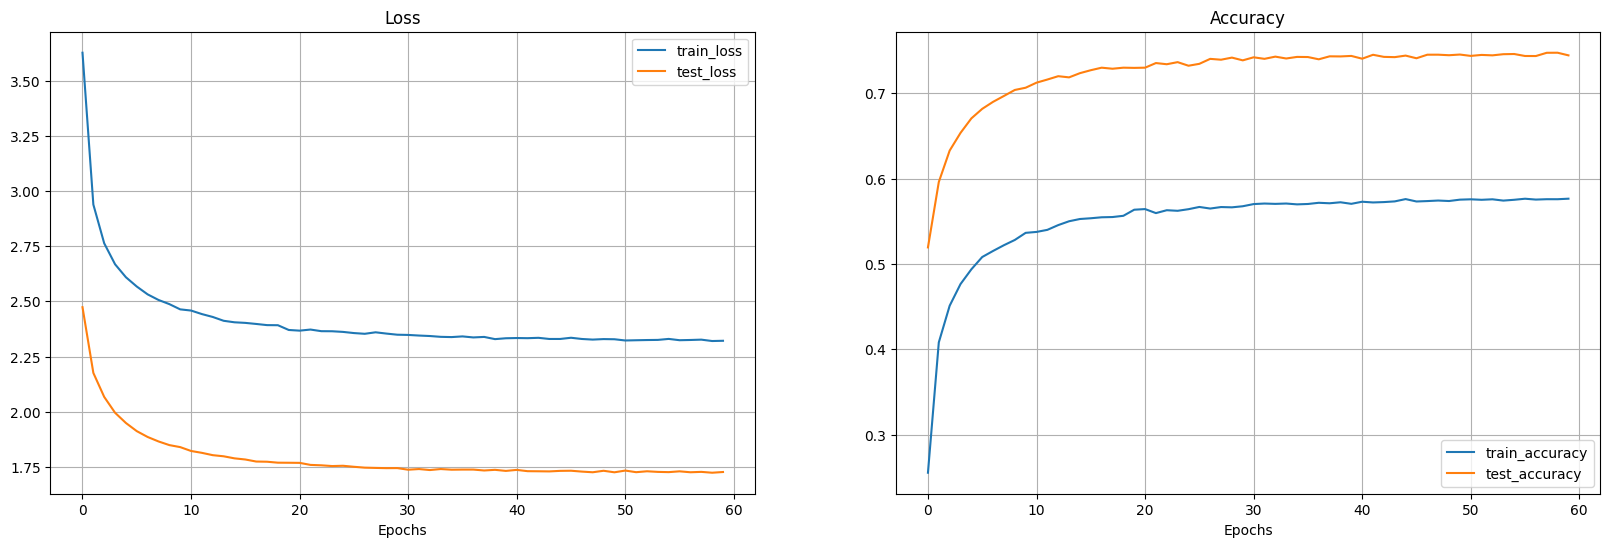

In [ ]:
# Train the model
if TRAIN['model_1']:
    model_type="vitbase16_1"
    EPOCHS = 60
    LR = 0.0001
    model_name = f"{model_type}"
    vitbase16_model_name = model_name + ".pth"
    vitbase16_results_df = model_name + ".csv"

    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitbase16_model.parameters(),
                                    lr=LR,
                                    betas=(0.9, 0.999),
                                    weight_decay=0.01
    )

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set scheduler
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1, eta_min=1e-6)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, min_lr=1e-7)

    # Set seeds
    set_seeds(SEED)

    # And train...
    vitbase16_results = train(model=vitbase16_model, 
                            train_dataloader=train_dataloader_vitb,
                            test_dataloader=test_dataloader_vitb,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            scheduler=None,
                            epochs=EPOCHS,
                            device=device,
                            plot_curves=True,
                            amp=True,
                            writer=None)

In [ ]:
# Save the model 
if TRAIN['model_1']:
    save_model(model=vitbase16_model,
                target_dir=model_dir,
                model_name=vitbase16_model_name)
    df_results = pd.DataFrame(vitbase16_results)
    df_results.to_csv(os.path.join(model_dir, vitbase16_results_df), index=False)  

[INFO] Saving model to: ..\models\vitbase16_1.pth


## 5.2. ViT-Base - 1024 Hidden Layer Units

| Version | **ViT Type**| **Image Size** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 2 | Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | 1024 | Yes | 60 | 0.0001 | No | 86.7M |

In [ ]:
# Create the ViT-Base model
if TRAIN['model_2']:

    # Create dataloaders
    train_dataloader_vitb, test_dataloader_vitb, class_names, pretrained_vitb_weights = data_loaders("vitbase16")

    # Instantiate the ViT-Base model
    vitbase16_2_model = ViT(
        img_size=IMG_SIZE,
        in_channels=3,
        patch_size=16,
        num_transformer_layers=12,
        emb_dim=768,
        mlp_size=3072,
        num_heads=12,
        attn_dropout=0,
        mlp_dropout=0.1,
        emb_dropout=0.1,
        classif_head_hidden_units=1024, # Add a hidder layer of 1024 neurons to the classification head
        num_classes=len(class_names)
    )

    # Copy weights from torchvision.models.ViT_B_16_Weights.DEFAULT (note: except the header to be trained)
    vitbase16_2_model.copy_weights(pretrained_vitb_weights)

    # And freeze the backbone except the classification head params
    #vitbase16_2_model.set_params_frozen(except_head=True)

    # Compile model
    vitbase16_2_model = torch.compile(vitbase16_2_model)

    # Print summary
    summary(vitbase16_2_model,
            input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"])

Epoch: 60 | train_loss: 2.0116 | train_acc: 0.6571 | train_time: 2m39s | test_loss: 1.6461 | test_acc: 0.7609 | test_time: 2m2s | lr: 0.0001000000


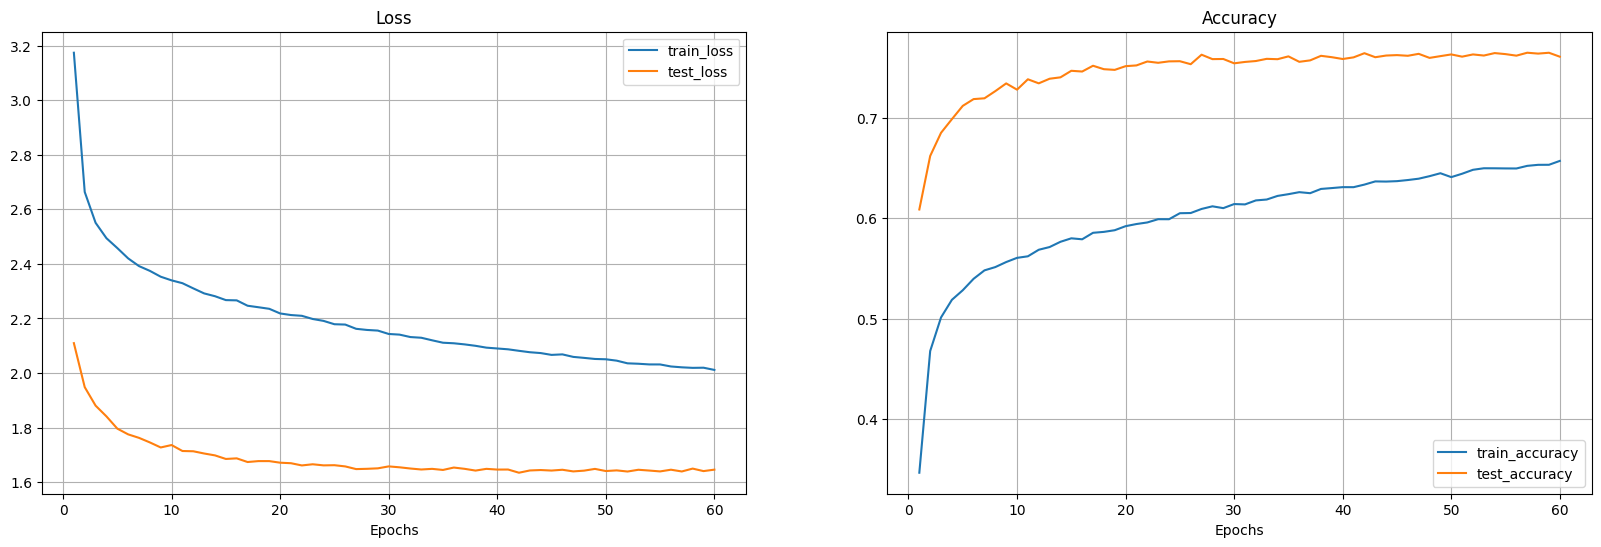

In [ ]:
# Train the model
if TRAIN['model_2']:
    model_type="vitbase16_2"
    EPOCHS = 60
    LR = 0.0001
    model_name = f"{model_type}"
    vitbase16_2_model_name = model_name + ".pth"
    vitbase16_2_results_df = model_name + ".csv"

    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitbase16_2_model.parameters(),
                                    lr=LR,
                                    betas=(0.9, 0.999),
                                    weight_decay=0.01
    )

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set seeds
    set_seeds(SEED)

    # And train...
    vitbase16_2_results = train(model=vitbase16_2_model, 
                            train_dataloader=train_dataloader_vitb,
                            test_dataloader=test_dataloader_vitb,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            scheduler=None,
                            epochs=EPOCHS,
                            device=device,
                            plot_curves=True,
                            amp=True,
                            writer=None)

In [ ]:
# Save the model 
if TRAIN['model_2']:
    save_model(model=vitbase16_2_model,
                target_dir=model_dir,
                model_name=vitbase16_2_model_name)
    df_results = pd.DataFrame(vitbase16_2_results)
    df_results.to_csv(os.path.join(model_dir, vitbase16_2_results_df), index=False)  

[INFO] Saving model to: ..\models\vitbase16_2.pth


## 5.3. ViT-Large - No Hidden Layer Units

| Version | **ViT Type** | **Image Size** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 3 | Large | 224x224 | 16x16 | 24 | 1024 | 4096 | 16 | None | Yes | 60 | 0.0001 | No | 303.4M |

In [ ]:
# Create the ViT-Large model
if TRAIN['model_3']:

    # Create dataloaders
    train_dataloader_vitl, test_dataloader_vitl, class_names, pretrained_vitl_weights = data_loaders("vitlarge16")

    # Instantiate the ViT-Large model
    vitlarge16_model = ViT(
        img_size=IMG_SIZE,
        in_channels=3,
        patch_size=16,
        num_transformer_layers=24,
        emb_dim=1024,
        mlp_size=4096,
        num_heads=16,
        attn_dropout=0,
        mlp_dropout=0.1,
        emb_dropout=0.1,
        num_classes=len(class_names)
    )

    # Copy weights from torchvision.models.ViT_L_16_Weights.DEFAULT (note: except the header to be trained)
    vitlarge16_model.copy_weights(pretrained_vitl_weights)

    # And freeze the backbone except the classification head params
    #vitlarge16_model.set_params_frozen(except_head=True)

    # Compile model
    vitlarge16_model = torch.compile(vitlarge16_model)

    # Print summary
    summary(vitlarge16_model,
            input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"])

In [ ]:
# Print summary of a pretrained model
#if TRAIN['model_3']:
#    summary(pretrained_vit,
#        input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
#        col_names=["input_size", "output_size", "num_params", "trainable"],
#        col_width=20,
#        row_settings=["var_names"])

In [ ]:
# Check out that the parameters have been sucessfully copied
#if TRAIN['model_3']:
#    print("Weights of the pretrained model")
#    for name, param in pretrained_vit.named_parameters():
#        print(f"{name}: {param.data.mean()}")

#    print("...................")
#    print("Weights of the ViTBase model")
#    for name, param in vitlarge16_model.named_parameters():
#        print(f"{name}: {param.data.mean()}")

Epoch: 60 | train_loss: 1.7480 | train_acc: 0.7467 | train_time: 5m46s | test_loss: 1.6416 | test_acc: 0.7725 | test_time: 4m58s | lr: 0.0001000000


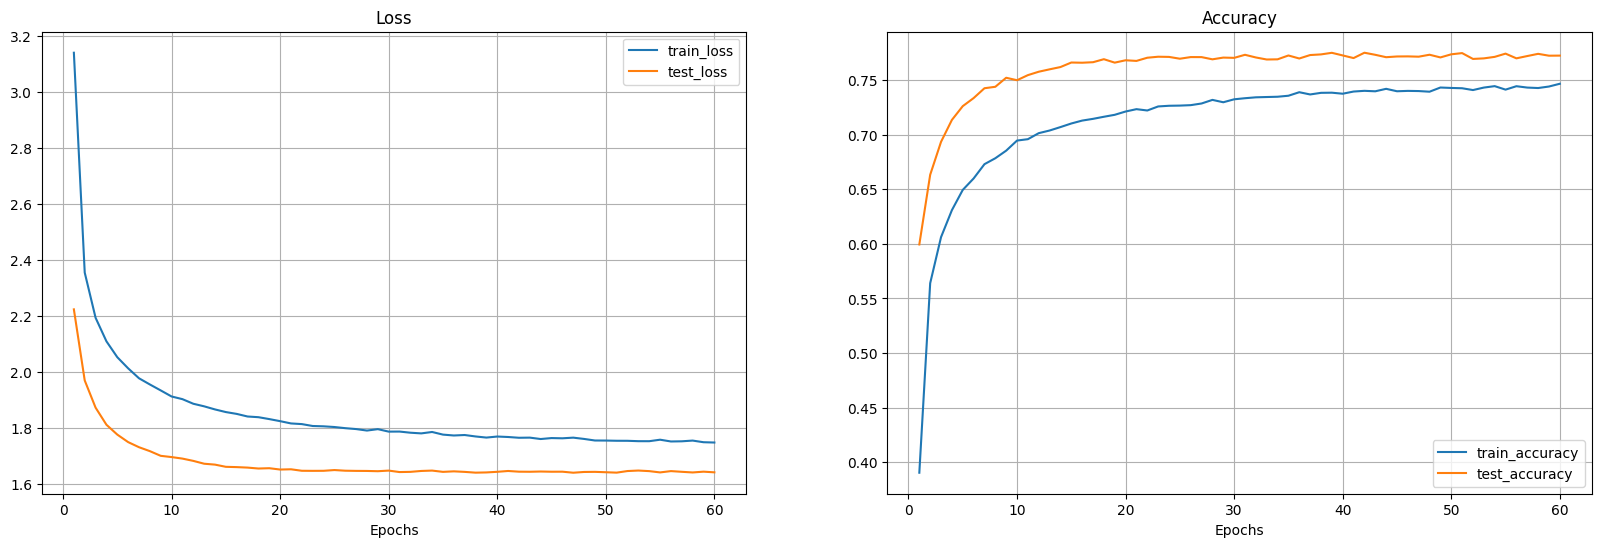

In [ ]:
# Train the model
if TRAIN['model_3']:
    model_type="vitlarge16_1"
    EPOCHS = 60
    LR = 0.0001
    model_name = f"{model_type}"
    vitlarge16_model_name = model_name + ".pth"
    vitlarge16_results_df = model_name + ".csv"

    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitlarge16_model.parameters(),
                                    lr=LR,
                                    betas=(0.9, 0.999),
                                    weight_decay=0.01
    )

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set seeds
    set_seeds(SEED)

    # And train...
    vitlarge16_results = train(model=vitlarge16_model, 
                            train_dataloader=train_dataloader_vitl,
                            test_dataloader=test_dataloader_vitl,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            scheduler=None,
                            epochs=EPOCHS,
                            device=device,
                            plot_curves=True,
                            amp=True,
                            writer=None)

In [ ]:
# Save the model
if TRAIN['model_3']: 
    save_model(model=vitlarge16_model,
                target_dir=model_dir,
                model_name=vitlarge16_model_name)
    df_results = pd.DataFrame(vitlarge16_results)
    df_results.to_csv(os.path.join(model_dir, vitlarge16_results_df), index=False)  

[INFO] Saving model to: ..\models\vitlarge16_1.pth


# 5.4. ViT-Large - 1024 Hidden Layer Units

| Version | **ViT Type** | **Image Size** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 4 | Large | 224x224 | 16x16 | 24 | 1024 | 4096 | 16 | 1024 | Yes | 20 | 0.0001 | No | 304.5M |

In [ ]:
# Create the ViT-Large model
if TRAIN['model_4']:

    # Create dataloaders
    train_dataloader_vitl, test_dataloader_vitl, class_names, pretrained_vitl_weights = data_loaders("vitlarge16")

    # Instantiate the ViT-Large model
    vitlarge16_2_model = ViT(
        img_size=IMG_SIZE,
        in_channels=3,
        patch_size=16,
        num_transformer_layers=24,
        emb_dim=1024,
        mlp_size=4096,
        num_heads=16,
        attn_dropout=0,
        mlp_dropout=0.1,
        emb_dropout=0.1,
        classif_head_hidden_units=1024,
        num_classes=len(class_names)
    )

    # Copy weights from torchvision.models.ViT_L_16_Weights.DEFAULT (note: except the header to be trained)
    vitlarge16_2_model.copy_weights(pretrained_vitl_weights)

    # And freeze the backbone except the classification head params
    vitlarge16_2_model.set_params_frozen(except_head=True)

    # Compile model
    #vitlarge16_2_model = torch.compile(vitlarge16_2_model)

    # Print sumary
    summary(vitlarge16_2_model,
            input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"])

In [ ]:
# Print summary of a pretrained model
#if TRAIN['model_4']:
#    summary(pretrained_vit,
#            input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
#            col_names=["input_size", "output_size", "num_params", "trainable"],
#            col_width=20,
#            row_settings=["var_names"])

In [ ]:
# Check out that the parameters have been sucessfully copied
#if TRAIN['model_4']:
#    print("Weights of the pretrained model")
#    for name, param in pretrained_vit.named_parameters():
#        print(f"{name}: {param.data.mean()}")

#    print("...................")
#    print("Weights of the ViTBase model")
#    for name, param in vitlarge16_2_model.named_parameters():
#        print(f"{name}: {param.data.mean()}")

In [ ]:
# Train the model
if TRAIN['model_4']:

    # Instantiate the ViT-Large model
    model_type="vitlarge16_2"
    EPOCHS = 20
    LR = 0.0001
    model_name = f"{model_type}"
    vitlarge16_2_model_name = model_name + ".pth"
    vitlarge16_2_results_df = model_name + ".csv"

    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitlarge16_2_model.parameters(),
                                    lr=LR,
                                    betas=(0.9, 0.999),
                                    weight_decay=0.01
    )

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set seeds
    set_seeds(SEED)

    # And train...
    vitlarge16_2_results = train(model=vitlarge16_2_model, 
                                train_dataloader=train_dataloader_vitl,
                                test_dataloader=test_dataloader_vitl,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                scheduler=None,
                                epochs=EPOCHS,
                                device=device,
                                plot_curves=True,
                                amp=True,
                                writer=None)

In [ ]:
# Save the model
if TRAIN['model_4']:
    save_model(model=vitlarge16_2_model,
                target_dir=model_dir,
                model_name=vitlarge16_2_model_name)
    df_results = pd.DataFrame(vitlarge16_2_results)
    df_results.to_csv(os.path.join(model_dir, vitlarge16_2_results_df), index=False)  

[INFO] Saving model to: ..\models\vitlarge16_2.pth


# 5.5. ViT-Base - No Hidden Layer Units - No Transfer Learning

| Version | **ViT Type** | **Image Size** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 5 | Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | None | No | 20 | 0.00001 | No | 85.9M |

In [ ]:
# Create the ViT-Base model
if TRAIN['model_5']:

    # Create dataloaders
    train_dataloader_vitb, test_dataloader_vitb, class_names, pretrained_vitb_weights = data_loaders("vitbase16")

    # Instantiate the ViT-Base model
    vitbase16_3_model = ViT(
        img_size=IMG_SIZE,
        in_channels=3,
        patch_size=16,
        num_transformer_layers=12,
        emb_dim=768,
        mlp_size=3072,
        num_heads=12,
        attn_dropout=0,
        mlp_dropout=0.1,
        emb_dropout=0.1,
        #classif_head_hidden_units=1024, # Add a hidder layer of 1024 neurons to the classification head
        num_classes=len(class_names)
    )

    # Copy weights from torchvision.models.ViT_B_16_Weights.DEFAULT (note: except the header to be trained)
    vitbase16_3_model.copy_weights(pretrained_vitb_weights)

    # And freeze the backbone except the classification head params
    #vitbase16_2_model.set_params_frozen(except_head=True)

    # Compile model
    #vitbase16_3_model = torch.compile(vitbase16_3_model)

    # Print summary
    summary(vitbase16_3_model,
            input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"])

Epoch: 20 | train_loss: 1.1955 | train_acc: 0.8853 | train_time: 5m54s | test_loss: 1.2310 | test_acc: 0.8680 | test_time: 2m7s | lr: 0.0000100000


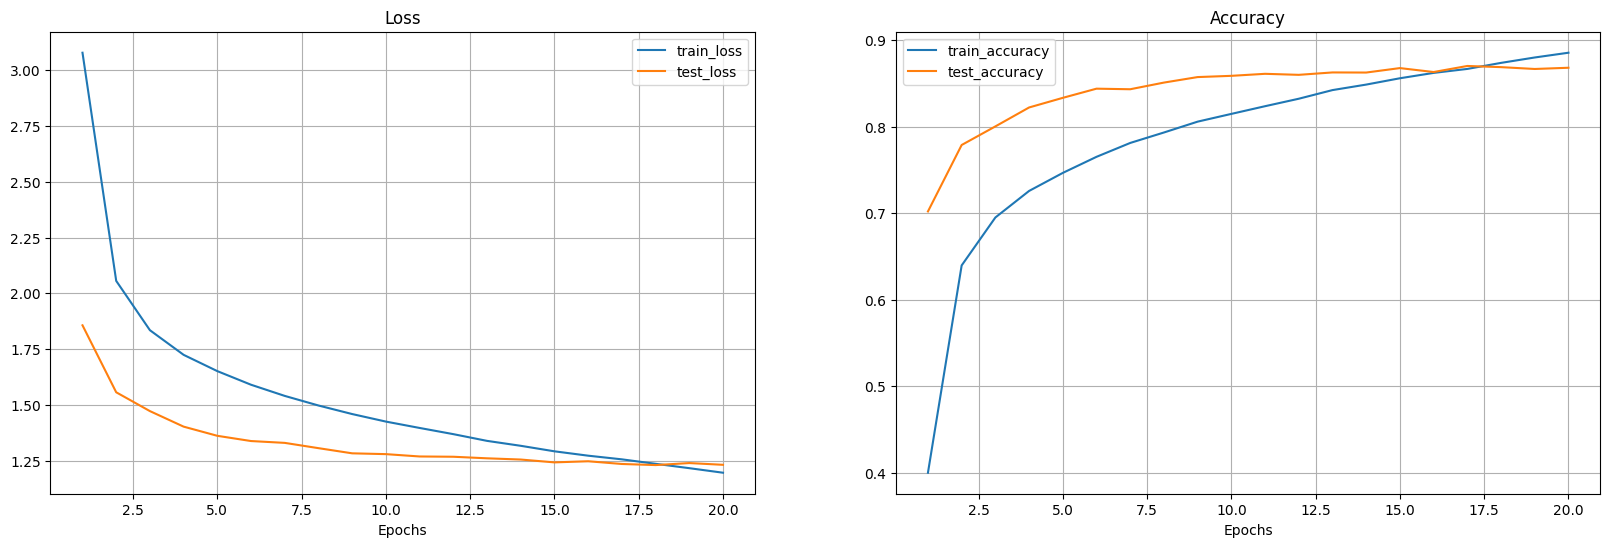

In [12]:
# Train the model
if TRAIN['model_5']:
    model_type="vitbase16_3"
    EPOCHS = 20
    LR = 0.00001
    model_name = f"{model_type}"
    vitbase16_3_model_name = model_name + ".pth"
    vitbase16_3_results_df = model_name + ".csv"

    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitbase16_3_model.parameters(),
                                    lr=LR,
                                    betas=(0.9, 0.999),
                                    weight_decay=0.01
    )

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set seeds
    set_seeds(SEED)

    # And train...
    vitbase16_3_results = train(model=vitbase16_3_model, 
                            train_dataloader=train_dataloader_vitb,
                            test_dataloader=test_dataloader_vitb,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            scheduler=None,
                            epochs=EPOCHS,
                            device=device,
                            plot_curves=True,
                            amp=True,
                            writer=None)

In [13]:
# Save the model 
if TRAIN['model_5']:
    save_model(model=vitbase16_3_model,
                target_dir=model_dir,
                model_name=vitbase16_3_model_name)
    df_results = pd.DataFrame(vitbase16_3_results)
    df_results.to_csv(os.path.join(model_dir, vitbase16_3_results_df), index=False)  

[INFO] Saving model to: ..\models\vitbase16_3.pth


# 5.6. ViT-Base - 1024 Hidden Layer Units - No Transfer Learning

| Version | **ViT Type** | **Image Size** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 6 | Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | 1024 | No | 20 | 0.00001 | No | 86.7M |

In [ ]:
# Create the ViT-Base model
if TRAIN['model_6']:

    # Create dataloaders
    train_dataloader_vitb, test_dataloader_vitb, class_names, pretrained_vitb_weights = data_loaders("vitbase16")

    # Instantiate the ViT-Base model
    vitbase16_4_model = ViT(
        img_size=IMG_SIZE,
        in_channels=3,
        patch_size=16,
        num_transformer_layers=12,
        emb_dim=768,
        mlp_size=3072,
        num_heads=12,
        attn_dropout=0,
        mlp_dropout=0.1,
        emb_dropout=0.1,
        classif_head_hidden_units=1024, # Add a hidder layer of 1024 neurons to the classification head
        num_classes=len(class_names)
    )

    # Copy weights from torchvision.models.ViT_B_16_Weights.DEFAULT (note: except the header to be trained)
    vitbase16_4_model.copy_weights(pretrained_vitb_weights)

    # And freeze the backbone except the classification head params
    #vitbase16_2_model.set_params_frozen(except_head=True)

    # Compile model
    #vitbase16_4_model = torch.compile(vitbase16_4_model)

    # Print summary
    summary(vitbase16_4_model,
            input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"])

Epoch: 20 | train_loss: 1.1982 | train_acc: 0.8813 | train_time: 5m57s | test_loss: 1.2205 | test_acc: 0.8673 | test_time: 2m4s | lr: 0.0000100000


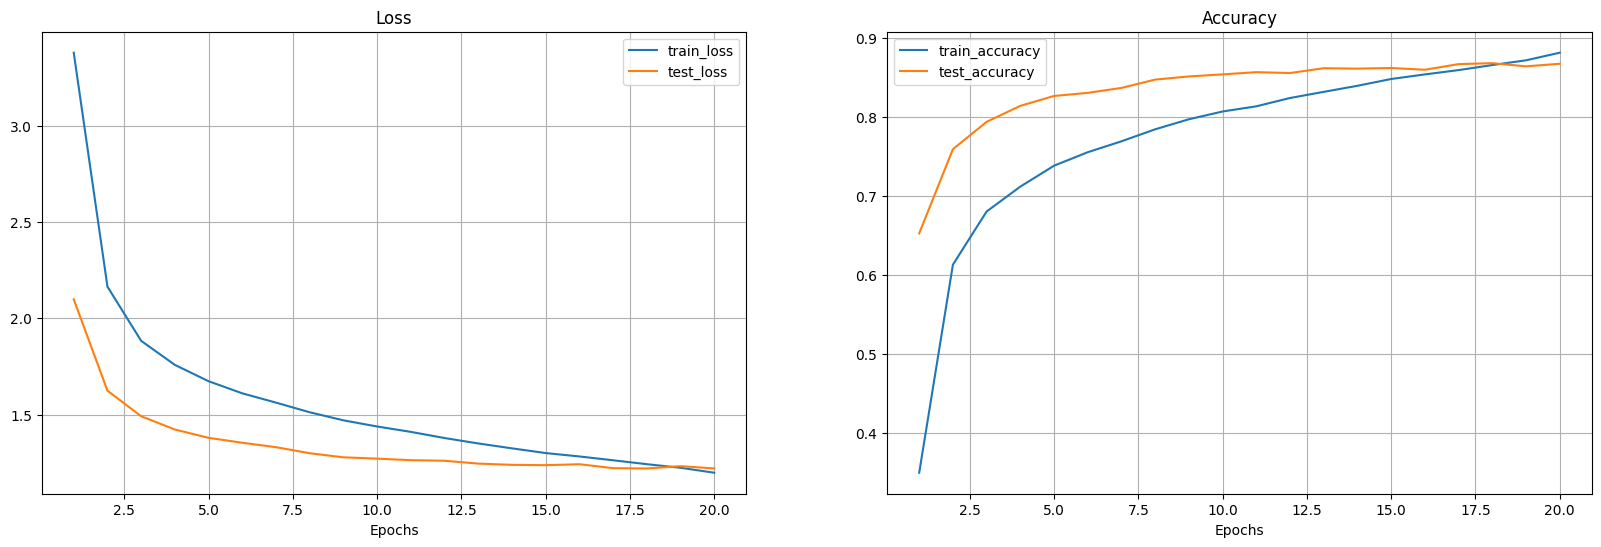

In [15]:
# Train the model
if TRAIN['model_6']:
    model_type="vitbase16_4"
    EPOCHS = 20
    LR = 0.00001
    model_name = f"{model_type}"
    vitbase16_4_model_name = model_name + ".pth"
    vitbase16_4_results_df = model_name + ".csv"

    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitbase16_4_model.parameters(),
                                    lr=LR,
                                    betas=(0.9, 0.999),
                                    weight_decay=0.01
    )

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set seeds
    set_seeds(SEED)

    # And train...
    vitbase16_4_results = train(model=vitbase16_4_model, 
                            train_dataloader=train_dataloader_vitb,
                            test_dataloader=test_dataloader_vitb,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            scheduler=None,
                            epochs=EPOCHS,
                            device=device,
                            plot_curves=True,
                            amp=True,
                            writer=None)

In [16]:
# Save the model 
if TRAIN['model_6']:
    save_model(model=vitbase16_4_model,
                target_dir=model_dir,
                model_name=vitbase16_4_model_name)
    df_results = pd.DataFrame(vitbase16_4_results)
    df_results.to_csv(os.path.join(model_dir, vitbase16_4_results_df), index=False)  

[INFO] Saving model to: ..\models\vitbase16_4.pth


# 5.7. ViT-Base - No Hidden Layer Units - No Transfer Learning - CosineAnnealingLR

| Version | **ViT Type** | **Image Size** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 7 | Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | None | No | 10 | 0.0001 | CosineAnnealingLR | 85.9M |

In [8]:
# Create the ViT-Base model
if TRAIN['model_7']:

    # Create dataloaders
    train_dataloader_vitb, test_dataloader_vitb, class_names, pretrained_vitb_weights = data_loaders("vitbase16")

    # Instantiate the ViT-Base model
    vitbase16_5_model = ViT(
        img_size=IMG_SIZE,
        in_channels=3,
        patch_size=16,
        num_transformer_layers=12,
        emb_dim=768,
        mlp_size=3072,
        num_heads=12,
        attn_dropout=0,
        mlp_dropout=0.1,
        emb_dropout=0.1,
        #classif_head_hidden_units=1024, # Add a hidder layer of 1024 neurons to the classification head
        num_classes=len(class_names)
    )

    # Copy weights from torchvision.models.ViT_B_16_Weights.DEFAULT (note: except the header to be trained)
    vitbase16_5_model.copy_weights(pretrained_vitb_weights)

    # Compile model
    #vitbase16_5_model = torch.compile(vitbase16_5_model)

    # Print summary
    summary(vitbase16_5_model,
            input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"])

Epoch: 10 | train_loss: 1.0248 | train_acc: 0.9387 | fpr_at_recall: 0.0011 | train_time: 5m57s | test_loss: 1.1934 | test_acc: 0.8774 | fpr_at_recall: 0.0082 | test_time: 2m4s | lr: 0.0000034227


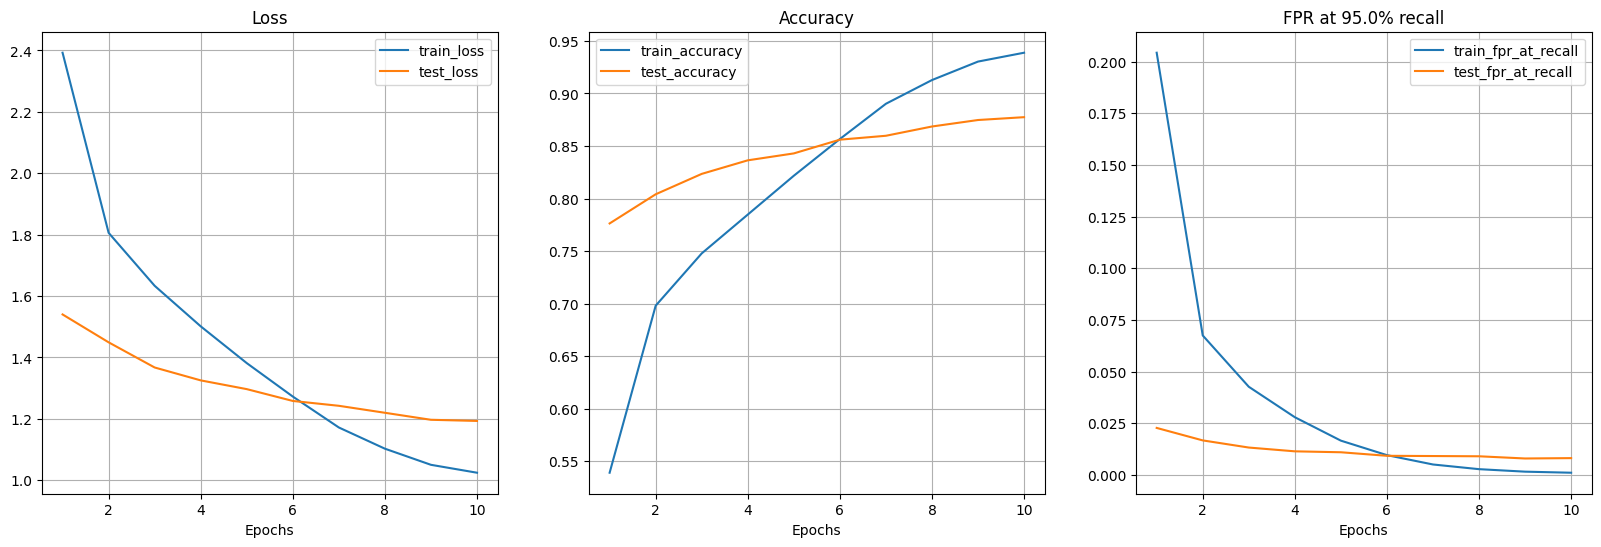

In [9]:
# Train the model
if TRAIN['model_7']:
    model_type="vitbase16_5"
    EPOCHS = 10
    LR = 0.0001
    model_name = f"{model_type}"
    vitbase16_5_model_name = model_name + ".pth"
    vitbase16_5_results_df = model_name + ".csv"

    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitbase16_5_model.parameters(),
                                    lr=LR,
                                    betas=(0.9, 0.999),
                                    weight_decay=0.01
    )

    # Set scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set seeds
    set_seeds(SEED)

    # And train...
    vitbase16_5_results = train(model=vitbase16_5_model, 
                                train_dataloader=train_dataloader_vitb,
                                test_dataloader=test_dataloader_vitb,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                recall_threshold=0.95,
                                scheduler=scheduler,
                                epochs=EPOCHS,
                                device=device,
                                plot_curves=True,
                                amp=True,
                                writer=None)

In [10]:
# Save the model 
if TRAIN['model_7']:
    save_model(model=vitbase16_5_model,
                target_dir=model_dir,
                model_name=vitbase16_5_model_name)
    df_results = pd.DataFrame(vitbase16_5_results)
    df_results.to_csv(os.path.join(model_dir, vitbase16_5_results_df), index=False)  

[INFO] Saving model to: ..\models\vitbase16_5.pth


In [14]:
pd.DataFrame(vitbase16_5_results)

,train_loss,train_acc,test_loss,test_acc,train_time [s],test_time [s],lr,train_fpr_at_recall,test_fpr_at_recall
0,2.392436,0.539143,1.540182,0.776298,367.317250,126.852905,0.000100,0.204308,0.022782
1,1.805976,0.698041,1.449407,0.804039,359.815828,124.753922,0.000098,0.067518,0.016745
2,1.633431,0.747798,1.367424,0.823441,358.259442,124.968192,0.000091,0.042699,0.013290
3,1.501464,0.784727,1.325448,0.836341,356.847662,124.467907,0.000080,0.027963,0.011461
4,1.381690,0.821678,1.296990,0.842924,356.230547,124.493843,0.000066,0.016625,0.011010
5,1.272768,0.856602,1.258474,0.855987,357.374070,124.140858,0.000051,0.009619,0.009296
6,1.172050,0.890153,1.242700,0.859705,356.925927,124.346208,0.000035,0.005096,0.009183
7,1.103026,0.912707,1.219964,0.868522,357.090943,124.666674,0.000021,0.002831,0.009065
8,1.050525,0.930290,1.197134,0.874693,358.261302,129.569437,0.000010,0.001623,0.007999
9,1.024775,0.938709,1.193399,0.877392,357.886866,124.631993,0.000003,0.001110,0.008174


# 5.8. ViT-Base - 1024 Hidden Layer Units - No Transfer Learning - CosineAnnealingLR

| Version | **ViT Type** | **Image Size** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 8 | Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | 1024 | No | 10 | 0.0001 | CosineAnnealingLR | 86.7M |

In [11]:
# Create the ViT-Base model
if TRAIN['model_8']:

    # Create dataloaders
    train_dataloader_vitb, test_dataloader_vitb, class_names, pretrained_vitb_weights = data_loaders("vitbase16")

    # Instantiate the ViT-Base model
    vitbase16_6_model = ViT(
        img_size=IMG_SIZE,
        in_channels=3,
        patch_size=16,
        num_transformer_layers=12,
        emb_dim=768,
        mlp_size=3072,
        num_heads=12,
        attn_dropout=0,
        mlp_dropout=0.1,
        emb_dropout=0.1,
        classif_head_hidden_units=1024, # Add a hidder layer of 1024 neurons to the classification head
        num_classes=len(class_names)
    )

    # Copy weights from torchvision.models.ViT_B_16_Weights.DEFAULT (note: except the header to be trained)
    vitbase16_6_model.copy_weights(pretrained_vitb_weights)

    # Compile model
    #vitbase16_6_model = torch.compile(vitbase16_6_model)

    # Print summary
    summary(vitbase16_6_model,
            input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"])

Epoch: 10 | train_loss: 1.0396 | train_acc: 0.9309 | fpr_at_recall: 0.0017 | train_time: 5m56s | test_loss: 1.1912 | test_acc: 0.8737 | fpr_at_recall: 0.0086 | test_time: 2m4s | lr: 0.0000034227


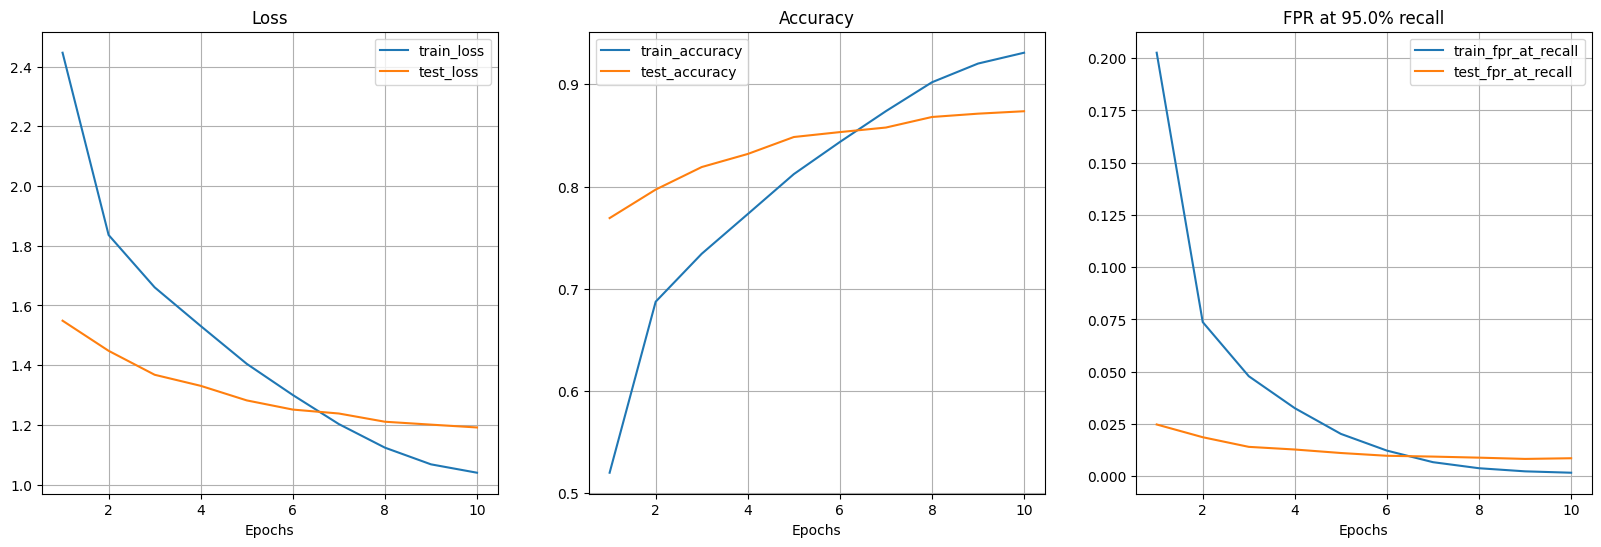

In [12]:
# Train the model
if TRAIN['model_8']:
    model_type="vitbase16_6"
    EPOCHS = 10
    LR = 0.0001
    model_name = f"{model_type}"
    vitbase16_6_model_name = model_name + ".pth"
    vitbase16_6_results_df = model_name + ".csv"

    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitbase16_6_model.parameters(),
                                  lr=LR,
                                  betas=(0.9, 0.999),
                                  weight_decay=0.01
    )

    # Set scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set seeds
    set_seeds(SEED)

    # And train...
    vitbase16_6_results = train(model=vitbase16_6_model, 
                                train_dataloader=train_dataloader_vitb,
                                test_dataloader=test_dataloader_vitb,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                recall_threshold=0.95,
                                scheduler=scheduler,
                                epochs=EPOCHS,
                                device=device,
                                plot_curves=True,
                                amp=True,
                                writer=None)

In [13]:
# Save the model 
if TRAIN['model_8']:
    save_model(model=vitbase16_6_model,
                target_dir=model_dir,
                model_name=vitbase16_6_model_name)
    df_results = pd.DataFrame(vitbase16_6_results)
    df_results.to_csv(os.path.join(model_dir, vitbase16_6_results_df), index=False)  

[INFO] Saving model to: ..\models\vitbase16_6.pth


# 5.9. ViT-Base - Multiple Classification Heads - No Transfer Learning - CosineAnnealingLR

| Version | **ViT Type** | **Image Size** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 9 | Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | Multiple | No | 10 | 0.0001 | CosineAnnealingLR | 87.9M |

In [8]:
# Create the ViT-Base model
if TRAIN['model_9']:

    # Create independent classifications heads with different numbers of hidden unit neurons
    head1 = nn.Sequential(
        nn.LayerNorm(normalized_shape=768),
        nn.Linear(in_features=768, out_features=1024),
        nn.GELU(),
        nn.Dropout(p=0.1),
        nn.Linear(in_features=1024, out_features=len(class_names))
        )
    
    head2 = nn.Sequential(
        nn.LayerNorm(normalized_shape=768),
        nn.Linear(in_features=768, out_features=768),
        nn.GELU(),
        nn.Dropout(p=0.1),
        nn.Linear(in_features=768, out_features=len(class_names))
    )

    head3 = nn.Sequential(
        nn.LayerNorm(normalized_shape=768),
        nn.Linear(in_features=768, out_features=512),
        nn.GELU(),
        nn.Dropout(p=0.1),
        nn.Linear(in_features=512, out_features=len(class_names))
    )

    head4 = nn.Sequential(
        nn.LayerNorm(normalized_shape=768),
        nn.Linear(in_features=768, out_features=len(class_names))
    )

    # Create dataloaders
    train_dataloader_vitb, test_dataloader_vitb, class_names, pretrained_vitb_weights = data_loaders("vitbase16")

    # Instantiate the ViT-Base model
    vitbase16_7_model = ViTv2(
        img_size=IMG_SIZE,
        in_channels=3,
        patch_size=16,
        num_transformer_layers=12,
        emb_dim=768,
        mlp_size=3072,
        num_heads=12,
        attn_dropout=0,
        mlp_dropout=0.1,
        emb_dropout=0.1,
        classif_heads=[head1, head2, head3, head4],
        num_classes=len(class_names)
    )

    # Copy weights from torchvision.models.ViT_B_16_Weights.DEFAULT (note: except the header to be trained)
    vitbase16_7_model.copy_weights(pretrained_vitb_weights)

    # Compile model
    #vitbase16_7_model = torch.compile(vitbase16_7_model)

In [9]:
# Print summary
summary(vitbase16_7_model,
        input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViTv2 (ViTv2)                                                [64, 3, 224, 224]    [64, 101]            --                   True
├─PatchEmbedding (embedder)                                  [64, 3, 224, 224]    [64, 197, 768]       152,064              True
│    └─Conv2d (conv_proj)                                    [64, 3, 224, 224]    [64, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [64, 768, 14, 14]    [64, 768, 196]       --                   --
│    └─Dropout (emb_dropout)                                 [64, 197, 768]       [64, 197, 768]       --                   --
├─Sequential (encoder)                                       [64, 197, 768]       [64, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [64, 197, 768]       [64, 197, 768]

Epoch: 10 | train_loss: 1.0296 | train_acc: 0.9317 | fpr_at_recall: 0.0015 | train_time: 6m8s | test_loss: 1.1867 | test_acc: 0.8752 | fpr_at_recall: 0.0083 | test_time: 2m7s | lr: 0.0000034227


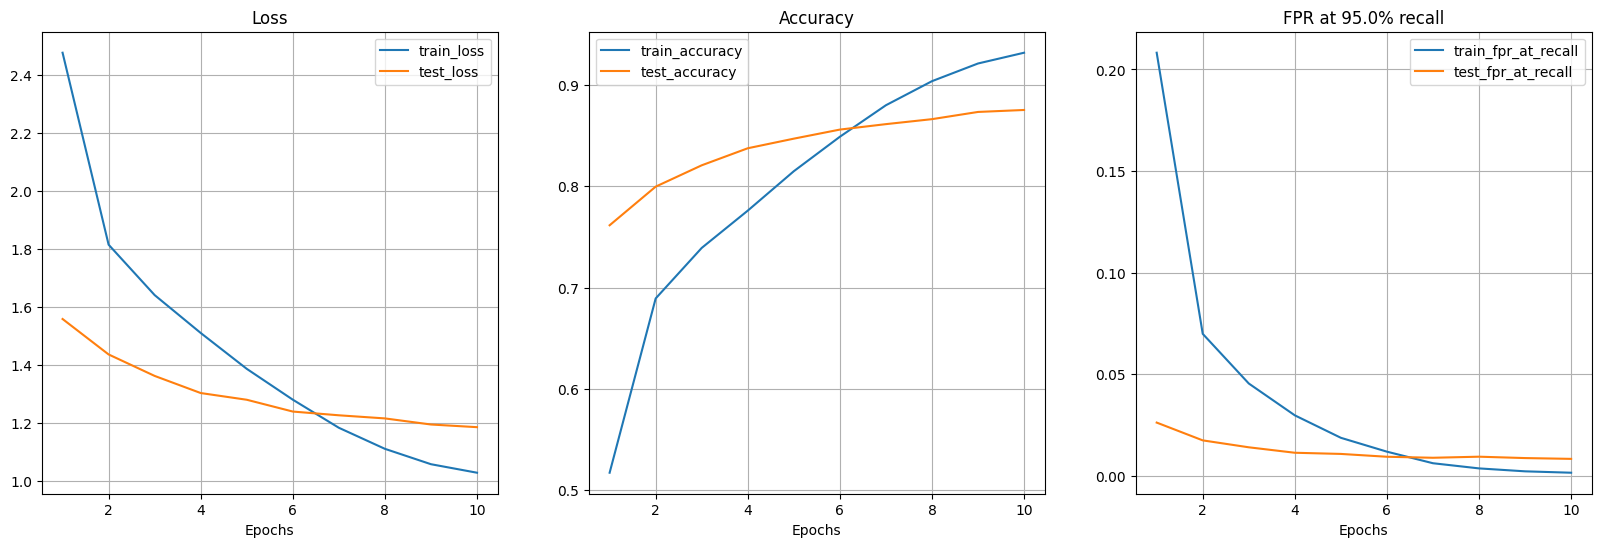

In [10]:
# Train the model
if TRAIN['model_9']:
    model_type="vitbase16_7"
    EPOCHS = 10
    LR = 0.0001
    model_name = f"{model_type}"
    vitbase16_7_model_name = model_name + ".pth"
    vitbase16_7_results_df = model_name + ".csv"

    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitbase16_7_model.parameters(),
                                  lr=LR,
                                  betas=(0.9, 0.999),
                                  weight_decay=0.01
    )

    # Set scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set seeds
    set_seeds(SEED)

    # And train...
    vitbase16_7_results = train(model=vitbase16_7_model, 
                                train_dataloader=train_dataloader_vitb,
                                test_dataloader=test_dataloader_vitb,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                recall_threshold=0.95,
                                scheduler=scheduler,
                                epochs=EPOCHS,
                                device=device,
                                plot_curves=True,
                                amp=True,
                                writer=None)

In [11]:
# Save the model 
if TRAIN['model_9']:
    save_model(model=vitbase16_7_model,
                target_dir=model_dir,
                model_name=vitbase16_7_model_name)
    df_results = pd.DataFrame(vitbase16_7_results)
    df_results.to_csv(os.path.join(model_dir, vitbase16_7_results_df), index=False)  

[INFO] Saving model to: ..\models\vitbase16_7.pth


# 5.10. ViT-Large - No Hidden Layer Units - No Transfer Learning
| Version | **ViT Type** | **Image Size** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 10 | Large | 224x224 | 16x16 | 24 | 1024 | 4096 | 16 | None | No | 10 | 0.00001 | No | 303.4M |

In [4]:
# Create the ViT-Large model
if TRAIN['model_10']:

    # Create dataloaders
    BATCH_SIZE=16
    train_dataloader_vitl, test_dataloader_vitl, class_names, pretrained_vitl_weights = data_loaders("vitlarge16", batch_size=BATCH_SIZE, aug=True, display_imgs=False)

    # Instantiate the ViT-Large model
    vitlarge16_3_model = ViT(
        img_size=IMG_SIZE,
        in_channels=3,
        patch_size=16,
        num_transformer_layers=24,
        emb_dim=1024,
        mlp_size=4096,
        num_heads=16,
        attn_dropout=0,
        mlp_dropout=0.1,
        emb_dropout=0.1,
        num_classes=len(class_names)
    )

    # Copy weights from torchvision.models.ViT_L_16_Weights.DEFAULT (note: except the header to be trained)
    vitlarge16_3_model.copy_weights(pretrained_vitl_weights)
    del pretrained_vitl_weights

    # And freeze the backbone except the classification head params
    #vitlarge16_3_model.set_params_frozen(except_head=True)

    # Compile model
    vitlarge16_3_model = torch.compile(vitlarge16_3_model, backend="aot_eager")

    # Print summary
    #display(summary(vitlarge16_3_model,
    #                input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
    #                col_names=["input_size", "output_size", "num_params", "trainable"],
    #                col_width=20,
    #                row_settings=["var_names"]))

[INFO] Model weights copied successfully.
[INFO] Model weights are trainable by default. Use function set_params_frozen to freeze them.


c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


Epoch: 2 | train_loss: 4.6865 | train_acc: 0.0100 | fpr_at_recall: 0.9500 | train_time: 18m48s | test_loss: 4.6400 | test_acc: 0.0099 | fpr_at_recall: 0.9111 | test_time: 3m28s | lr: 0.0009972612


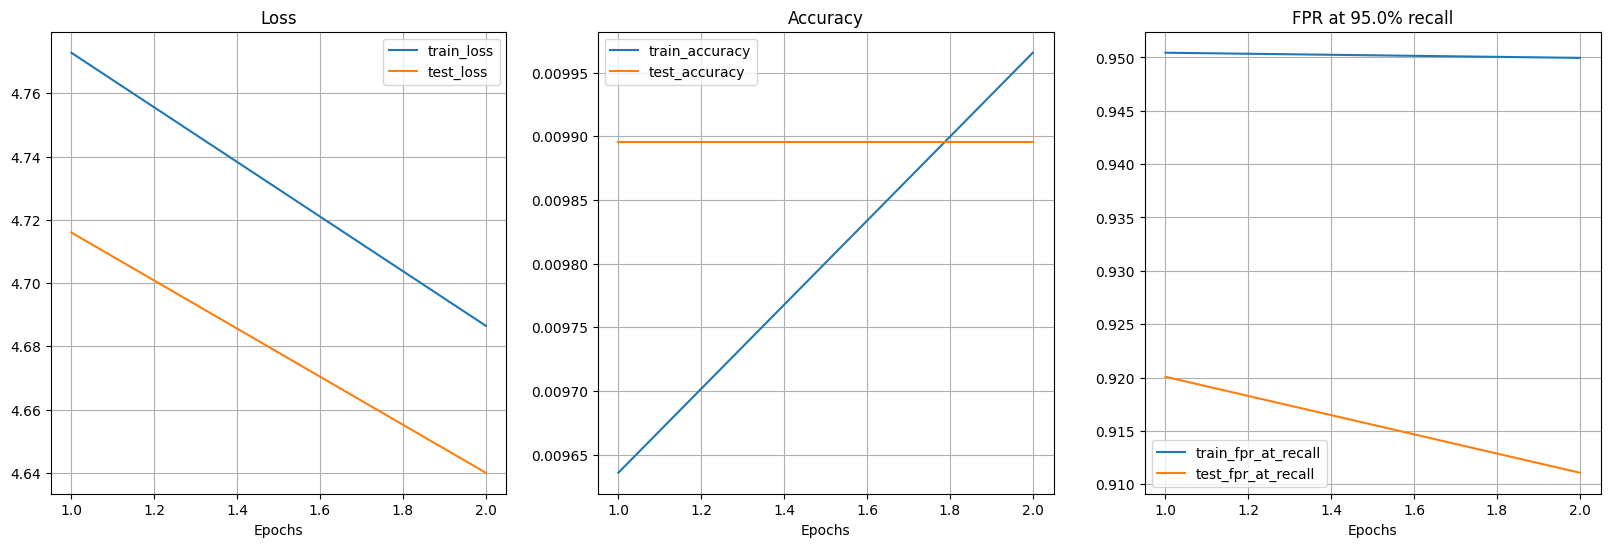

Training epoch 3...


  0%|          | 0/4735 [00:00<?, ?it/s]

c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\MHA.cpp:676.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [ ]:
# Train the model
if TRAIN['model_10']:
    model_type="vitlarge16_3"
    EPOCHS = 30
    LR = 0.00001
    accumulation_steps = 4 # BATCH_SIZE x ACCUMULATION_STEPS: 32 x 2 = 64
    model_name = f"{model_type}"
    vitlarge16_3_model_name = model_name + ".pth"

    # Create optimizer
    #parameters = [
    #    {"params": vitlarge16_3_model.embedder.parameters(), "lr": 1e-5},
    #    {"params": vitlarge16_3_model.encoder.parameters(), "lr": 1e-5},
    #    {"params": vitlarge16_3_model.classifier.parameters(), "lr": 1e-4}
    #]
        
    optimizer = torch.optim.AdamW(
        params=vitlarge16_3_model.parameters(),
        betas=(0.9, 0.999),
        weight_decay=0.01
        )
    
    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-7)

    # Set seeds
    set_seeds(SEED)

    # And train...
    train = Trainer(
        model=vitlarge16_3_model,
        save_best_model=True,
        mode="max", # Based on accuracy
        device=device)

    vitlarge32_1_results = train.fit(
        target_dir=model_dir,
        model_name=vitlarge16_3_model_name,
        train_dataloader=train_dataloader_vitl,
        test_dataloader=test_dataloader_vitl,
        optimizer=optimizer,
        loss_fn=loss_fn,
        recall_threshold=0.95,
        scheduler=scheduler,
        epochs=EPOCHS,
        amp=True,
        enable_clipping=False,
        debug_mode=False,
        accumulation_steps=accumulation_steps,
    )

The training time for the ViT-Large architecture withtout transfer learning cannot be afforded with an RTX4070 GPU.

# 5.11. PyTorch's Default ViT-Base - No Hidden Layer Units - No Transfer Learning
| Version | **ViT Type** | **Image Size** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 11 | Pytorch's Default Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | None | No | 10 | 0.0001 | CosineAnnealingLR | 85.9M |

In [8]:
# Create the ViT-Base model
if TRAIN['model_11']:

    # Create dataloaders
    train_dataloader_vitb, test_dataloader_vitb, class_names, pretrained_vitb_weights = data_loaders("vitbase16")    

    # Instatiate the model
    vitbase16_8_model = create_vit("vitbase16")

    # Compile model
    #vitbase16_8_model = torch.compile(vitbase16_8_model)

In [9]:
# Print summary
if TRAIN['model_11']:
    display(summary(vitbase16_8_model,
            input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"]))

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [64, 3, 224, 224]    [64, 101]            768                  True
├─Conv2d (conv_proj)                                         [64, 3, 224, 224]    [64, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                          [64, 197, 768]       [64, 197, 768]       151,296              True
│    └─Dropout (dropout)                                     [64, 197, 768]       [64, 197, 768]       --                   --
│    └─Sequential (layers)                                   [64, 197, 768]       [64, 197, 768]       --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [64, 197, 768]       [64, 197, 768]       7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [64, 197, 768]       [64, 197, 76

Epoch: 10 | train_loss: 0.9219 | train_acc: 0.9634 | fpr_at_recall: 0.0003 | train_time: 5m49s | test_loss: 1.1668 | test_acc: 0.8829 | fpr_at_recall: 0.0075 | test_time: 2m4s | lr: 0.0000034227


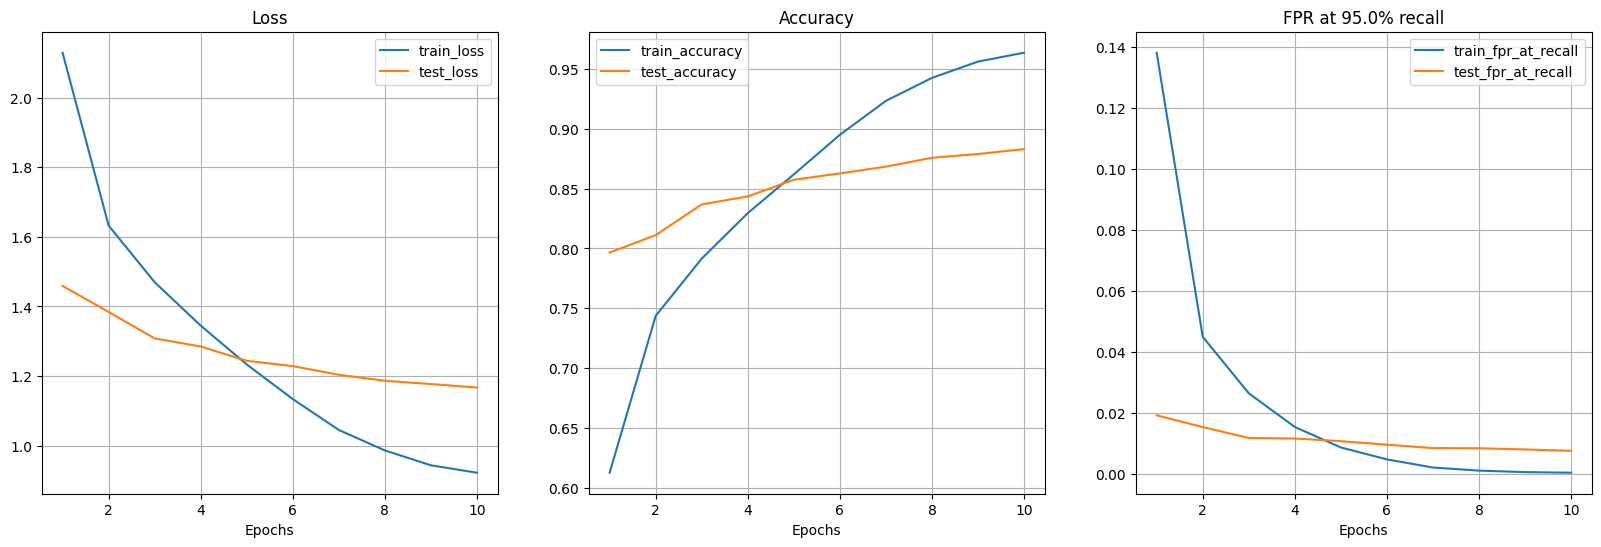

In [10]:
# Train the model
if TRAIN['model_11']:
    model_type="vitbase16_8"
    EPOCHS = 10
    LR = 0.0001
    model_name = f"{model_type}"
    vitbase16_8_model_name = model_name + ".pth"
    vitbase16_8_results_df = model_name + ".csv"

    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitbase16_8_model.parameters(),
                                  lr=LR,
                                  betas=(0.9, 0.999),
                                  weight_decay=0.01
    )

    # Set scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set seeds
    set_seeds(SEED)

    # And train...
    vitbase16_8_results = train(model=vitbase16_8_model, 
                                train_dataloader=train_dataloader_vitb,
                                test_dataloader=test_dataloader_vitb,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                recall_threshold=0.95,
                                scheduler=scheduler,
                                epochs=EPOCHS,
                                device=device,
                                plot_curves=True,
                                amp=True,
                                writer=None)

The results obtained with PyTorch's default ViT-Base model are comparable to the custom ViT model, proving that the custom ViT class works as expected.

In [11]:
# Save the model 
#if TRAIN['model_11']:
#    save_model(model=vitbase16_8_model,
#                target_dir=model_dir,
#                model_name=vitbase16_8_model_name)
#    df_results = pd.DataFrame(vitbase16_8_results)
#    df_results.to_csv(os.path.join(model_dir, vitbase16_8_results_df), index=False)  

[INFO] Saving model to: ..\models\vitbase16_8.pth


# 5.12. Increasing the Image Size - No Hidden Layer Units - No Transfer Learning
| Version | **ViT Type** | **Image Size** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 12 | Base | 256x256 | 16x16 | 12 | 768 | 3072 | 12 | None | No | 10 | 0.000001 | None | 85.9M |

In [4]:
# Image size
IMG_SIZE = 256

# Manual transforms for the training dataset
manual_transforms = v2.Compose([           
    v2.RandomCrop((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),    
])

# ViT-Base transforms

# Manual transforms for the training dataset
manual_transforms_aug_norm_train_vitb = v2.Compose([    
    v2.TrivialAugmentWide(),
    v2.Resize((296, 296)),
    v2.RandomCrop((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]) 
])

# Manual transforms for the test dataset
manual_transforms_aug_norm_test_vitb = v2.Compose([    
    v2.Resize((296, 296)),
    v2.CenterCrop((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]) 
])

# Create data loaders for ViT-Base
train_dataloader_vitb, test_dataloader_vitb, class_names = create_dataloaders(
    train_dir=TRAIN_DIR,
    test_dir=TRAIN_DIR,
    train_transform=manual_transforms_aug_norm_train_vitb,
    test_transform=manual_transforms_aug_norm_test_vitb,
    batch_size=BATCH_SIZE
)

# Get the pretrained ViT-Base weights
pretrained_vitb_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

In [7]:
# Create the ViT-Base model
if TRAIN['model_12']:
    vitbase16_9_model = ViT(
        img_size=IMG_SIZE,
        in_channels=3,
        patch_size=16,
        num_transformer_layers=12,
        emb_dim=768,
        mlp_size=3072,
        num_heads=12,
        attn_dropout=0,
        mlp_dropout=0.1,
        emb_dropout=0.1,
        #classif_head_hidden_units=1024, # Add a hidder layer of 1024 neurons to the classification head
        num_classes=len(class_names)
    )

    # Compile model
    vitbase16_9_model = torch.compile(vitbase16_9_model, backend="aot_eager")
    
    # Compile model
    #vitbase16_9_model = torch.compile(vitbase16_9_model, backend="cudagraphs")
    #vitbase16_9_model = torch.compile(vitbase16_9_model, backend="eager")
    #vitbase16_9_model = torch.compile(vitbase16_9_model, backend="aot_eager")
    #vitbase16_9_model = torch.compile(vitbase16_9_model, backend="inductor")
    #vitbase16_9_model = torch.compile(vitbase16_9_model, backend="onnxrt")
    #vitbase16_9_model = torch.compile(vitbase16_9_model)
    #vitbase16_9_model = vitbase16_9_model.compile(backend="aot_eager")

Epoch: 94 | train_loss: 3.2309 | train_acc: 0.3002 | fpr_at_recall: 0.3969 | train_time: 7m32s | test_loss: 3.2085 | test_acc: 0.3022 | fpr_at_recall: 0.3311 | test_time: 2m35s | lr: 0.0000010000


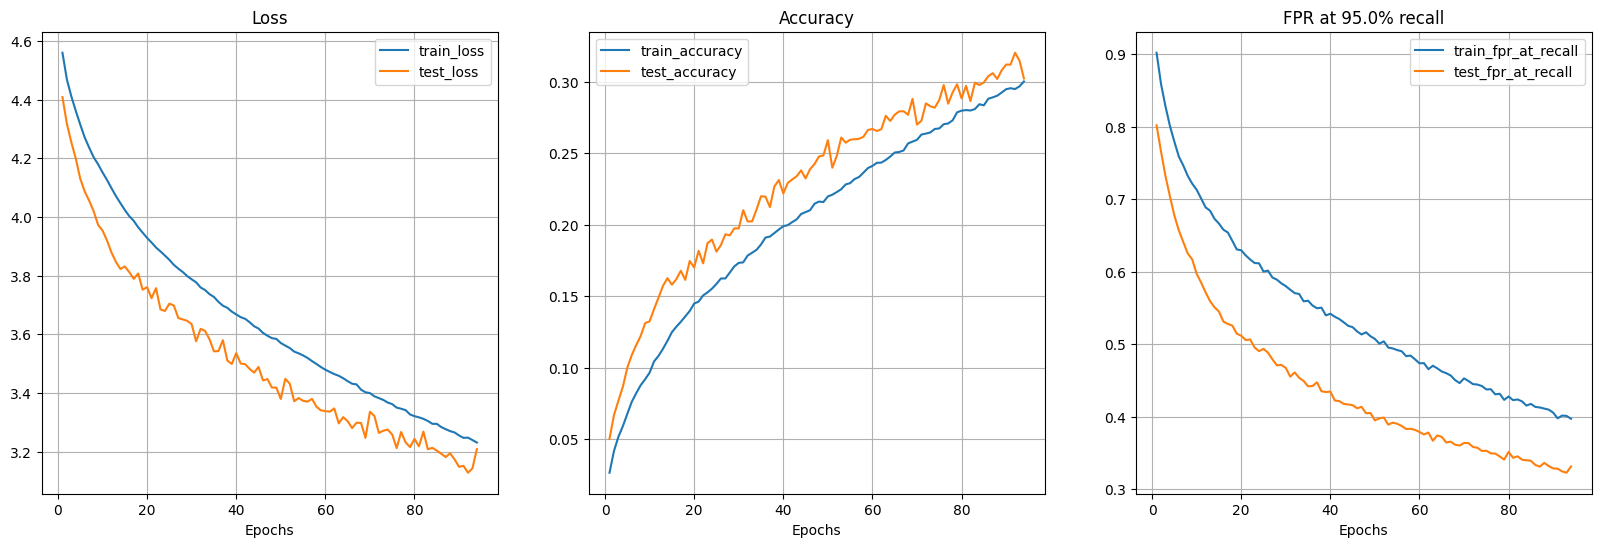

Training epoch 95...


  0%|          | 0/1184 [00:00<?, ?it/s]

c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\MHA.cpp:676.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [ ]:
if TRAIN['model_12']:
    model_type="vitbase16_9"
    EPOCHS = 300
    LR = 1e-6
    model_name = f"{model_type}"
    vitbase16_9_model_name = model_name + ".pth"

    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitbase16_9_model.parameters(),
                                  lr=LR,
                                  betas=(0.9, 0.999),
                                  weight_decay=0.01
    )

    # Set scheduler
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-7)

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set seeds
    set_seeds(SEED)

    # And train...
    vitbase16_9_results = train(model=vitbase16_9_model,
                                target_dir=model_dir,
                                model_name=vitbase16_9_model_name,
                                train_dataloader=train_dataloader_vitb,
                                test_dataloader=test_dataloader_vitb,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                recall_threshold=0.95,
                                scheduler=None,
                                epochs=EPOCHS,
                                device=device,
                                plot_curves=True,
                                amp=True,
                                save_best_model=True,
                                writer=None)

Epoch: 144 | train_loss: 2.5130 | train_acc: 0.4926 | fpr_at_recall: 0.2037 | train_time: 7m44s | test_loss: 2.7846 | test_acc: 0.4239 | fpr_at_recall: 0.2592 | test_time: 2m38s | lr: 0.0000010000


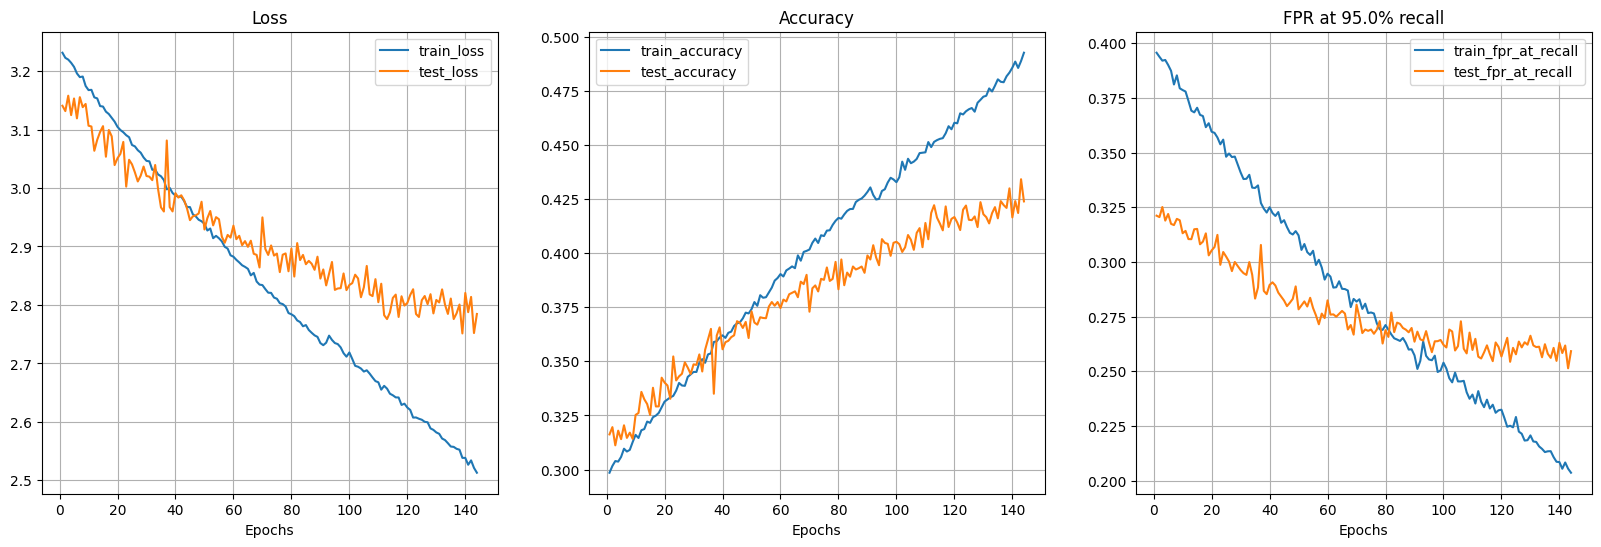

Training epoch 145...


  0%|          | 0/1184 [00:00<?, ?it/s]

c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\MHA.cpp:676.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


KeyboardInterrupt: 

In [11]:
if TRAIN['model_12']:
    vitbase16_9_model = ViT(
        img_size=IMG_SIZE,
        in_channels=3,
        patch_size=16,
        num_transformer_layers=12,
        emb_dim=768,
        mlp_size=3072,
        num_heads=12,
        attn_dropout=0,
        mlp_dropout=0.1,
        emb_dropout=0.1,
        #classif_head_hidden_units=1024, # Add a hidder layer of 1024 neurons to the classification head
        num_classes=len(class_names)
    )

    vitbase16_9_model = torch.compile(vitbase16_9_model, backend="aot_eager")
    
    vitbase16_9_model = load_model(
        model=vitbase16_9_model,
        model_weights_dir=model_dir,
        model_weights_name="vitbase16_9_best.pth",
    )
    model_type="vitbase16_9"
    EPOCHS = 215
    LR = 1e-6
    model_name = f"{model_type}"
    vitbase16_9_model_name = model_name + ".pth"

    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitbase16_9_model.parameters(),
                                  lr=LR,
                                  betas=(0.9, 0.999),
                                  weight_decay=0.01
    )

    # Set scheduler
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-7)

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set seeds
    set_seeds(SEED)

    # And train...
    vitbase16_9_results = train(model=vitbase16_9_model,
                                target_dir=model_dir,
                                model_name=vitbase16_9_model_name,
                                train_dataloader=train_dataloader_vitb,
                                test_dataloader=test_dataloader_vitb,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                recall_threshold=0.95,
                                scheduler=None,
                                epochs=EPOCHS,
                                device=device,
                                plot_curves=True,
                                amp=True,
                                save_best_model=True,
                                writer=None)

# 5.13. PyTorch's Default ViT-Base - No Hidden Layer Units - No Transfer Learning - More Epochs
| Version | **ViT Type** | **Image Size** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 13 | Pytorch's Default Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | None | No | 15 | 0.0001 | CosineAnnealingLR | 85.9M |

In [10]:
# Create the ViT-Base model
if TRAIN['model_13']:

    # Create dataloaders
    train_dataloader_vitb, test_dataloader_vitb, class_names, pretrained_vitb_weights = data_loaders("vitbase16")    

    # Instatiate the model
    vitbase16_10_model = create_vit("vitbase16")
    vitbase16_10_model = torch.compile(vitbase16_10_model, backend="aot_eager")

c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


Epoch: 15 | train_loss: 0.8691 | train_acc: 0.9765 | fpr_at_recall: 0.0001 | train_time: 6m32s | test_loss: 1.1897 | test_acc: 0.8822 | fpr_at_recall: 0.0098 | test_time: 2m4s | lr: 0.0000020817


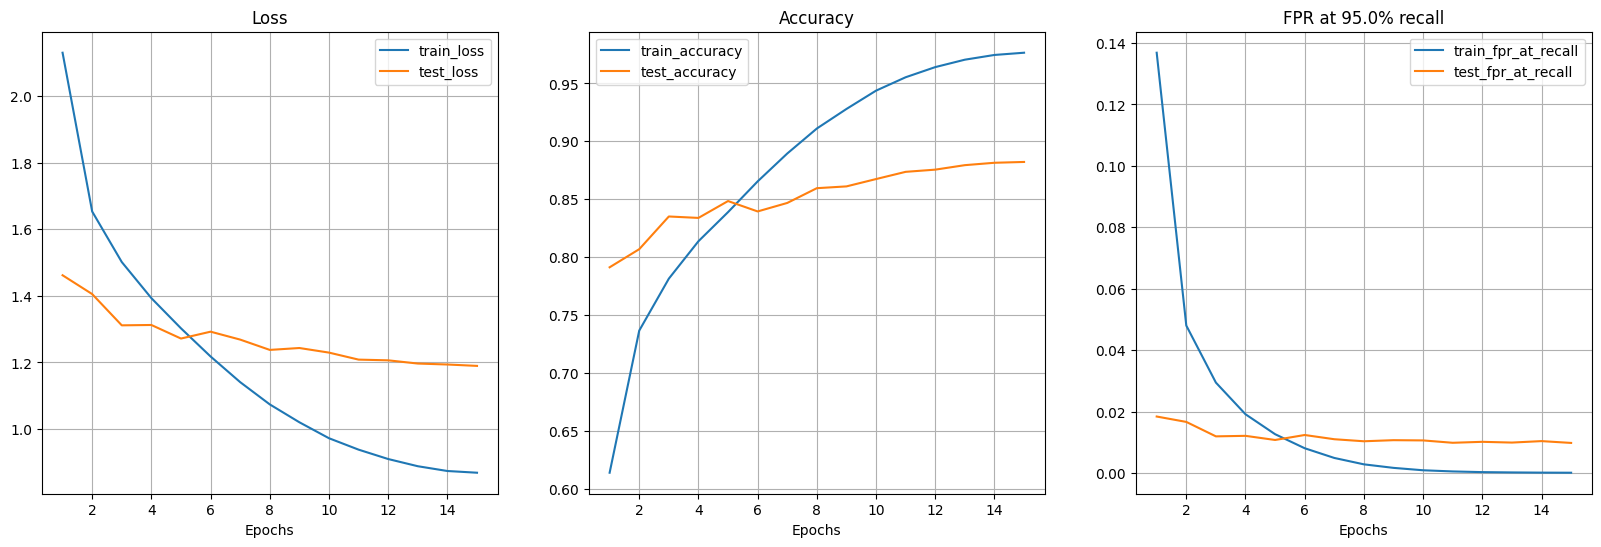

[INFO] Saving model to: ..\models\vitbase16_10_best.pth
[INFO] Saving model to: ..\models\vitbase16_10.pth


In [11]:
# Train the model
if TRAIN['model_13']:
    model_type="vitbase16_10"
    EPOCHS = 15
    #WARMUP_EPOCHS = 5
    LR = 0.0001
    model_name = f"{model_type}"
    vitbase16_10_model_name = model_name + ".pth"

    # Create optimizer
    optimizer = torch.optim.AdamW(
        params=vitbase16_10_model.parameters(),
        lr=LR,
        betas=(0.9, 0.999),
        weight_decay=0.01
        )
    
    #optimizer = torch.optim.SGD(vitbase16_10_model.parameters(),
    #                            lr=LR,
    #                            momentum=0.9,
    #                            weight_decay=0.01)

    # Set scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)
    #scheduler = WarmupCosineSchedule(optimizer=optimizer, warmup_epochs=5, t_total_epochs=EPOCHS)
    #scheduler = WarmupCosineAnnealingLR(
    #    optimizer=optimizer,
    #    warmup_epochs=WARMUP_EPOCHS,
    #    T_max=EPOCHS,
    #    eta_min=1e-6)

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set seeds
    set_seeds(SEED)

    # And train...
    train = Trainer(
        model=vitbase16_10_model,
        save_best_model=True,
        mode="max", # Based on accuracy
        device=device)

    vitbase16_10_results = train.fit(
        target_dir=model_dir,
        model_name=vitbase16_10_model_name,
        train_dataloader=train_dataloader_vitb,
        test_dataloader=test_dataloader_vitb,
        optimizer=optimizer,
        loss_fn=loss_fn,
        recall_threshold=0.95,
        scheduler=scheduler,
        epochs=EPOCHS,
        amp=True,
        enable_clipping=True,
        debug_mode=False,
    )